## Dependencias 

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import accuracy_score,classification_report,roc_auc_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OneHotEncoder
from varclushi import VarClusHi
from CreditScoringToolkit import frequency_table,DiscreteNormalizer
from functools import reduce 

## Lectura de datos 

In [5]:
df = pd.read_parquet('../data/churn.parquet')
print(df.shape)
display(df.head())

(2801, 14)


,V_ACCT_LGHT,C_IP,C_VMP,V_N_VM_MESS,V_T_DAY_CHG,V_T_EVE_CALLS,V_T_EVE_CHG,V_T_NIG_CALLS,V_T_NIG_CHG,V_T_INT_CALLS,V_T_INT_CHG,V_CS_CALLS,TARGET,ID
0,128.0,No,Yes,25.0,45.07,99.0,16.78,91.0,11.01,3.0,2.70,1.0,0.0,1.0
1,107.0,No,Yes,26.0,27.47,103.0,16.62,103.0,11.45,3.0,3.70,1.0,0.0,2.0
2,137.0,No,No,0.0,41.38,110.0,10.30,104.0,7.32,5.0,3.29,0.0,0.0,3.0
3,65.0,No,No,0.0,21.95,83.0,19.42,111.0,9.40,6.0,3.43,4.0,1.0,11.0
4,168.0,No,No,0.0,21.90,71.0,8.92,128.0,6.35,2.0,3.02,1.0,0.0,13.0


## Naturaleza de las variables 

In [6]:
varc = [v for v in df.columns if v[:2]=='V_']
vard = [v for v in df.columns if v[:2]=='C_']
vart = ['TARGET']
um = ['ID']

In [7]:
for v in varc:
    df[v] = pd.to_numeric(df[v],errors='coerce')
for v in vard:
    df[v] = df[v].fillna('MISSING').astype(str)

## Particion de datos  

In [8]:
train,valid = train_test_split(df,test_size=0.3,random_state=2014)
train.reset_index(drop=True,inplace=True)
valid.reset_index(drop=True,inplace=True)
train.shape,valid.shape

((1960, 14), (841, 14))

## Análisis exploratorio de datos 

### Continuo

#### Ausentes 

In [9]:
miss = (train[varc].isnull().sum()/len(train)).to_frame('pct_miss')
miss

,pct_miss
V_ACCT_LGHT,0.0
V_N_VM_MESS,0.0
V_T_DAY_CHG,0.0
V_T_EVE_CALLS,0.0
V_T_EVE_CHG,0.0
V_T_NIG_CALLS,0.0
V_T_NIG_CHG,0.0
V_T_INT_CALLS,0.0
V_T_INT_CHG,0.0
V_CS_CALLS,0.0


#### Varianza 

In [10]:
vt = VarianceThreshold(threshold=0)
vt.fit(train[varc])

VarianceThreshold(threshold=0)

In [11]:
fuera = [v for v,s in zip(varc,vt.get_support()) if not s]
print(fuera)
varc = [v for v in varc if v not in fuera]
train.drop(columns=fuera,inplace=True)

[]


#### Extremos 

In [12]:
display(train[varc].describe())
for v,li,ls in train[varc].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    train[v] = train[v].clip(lower=li,upper=ls)
display(train[varc].describe())

,V_ACCT_LGHT,V_N_VM_MESS,V_T_DAY_CHG,V_T_EVE_CALLS,V_T_EVE_CHG,V_T_NIG_CALLS,V_T_NIG_CHG,V_T_INT_CALLS,V_T_INT_CHG,V_CS_CALLS
count,1960.000000,1960.000000,1960.000000,1960.000000,1960.000000,1960.000000,1960.000000,1960.000000,1960.000000,1960.000000
mean,101.819898,7.963265,30.464138,100.511224,17.205408,100.387245,9.078199,4.477551,2.782276,1.541837
std,37.823233,13.470164,8.650342,18.552710,4.025773,18.252680,2.127404,2.289311,0.692972,1.275394
min,12.000000,0.000000,8.810000,53.000000,6.740000,57.000000,3.570000,1.000000,0.890000,0.000000
25%,75.000000,0.000000,24.475000,87.000000,14.260000,88.000000,7.620000,3.000000,2.320000,1.000000
50%,101.500000,0.000000,30.310000,101.000000,17.320000,101.000000,9.140000,4.000000,2.780000,1.000000
75%,129.000000,18.250000,36.640000,113.000000,20.110000,113.000000,10.570000,6.000000,3.270000,2.000000
max,195.000000,43.000000,51.880000,147.000000,27.120000,147.000000,14.300000,13.000000,4.510000,6.000000


,V_ACCT_LGHT,V_N_VM_MESS,V_T_DAY_CHG,V_T_EVE_CALLS,V_T_EVE_CHG,V_T_NIG_CALLS,V_T_NIG_CHG,V_T_INT_CALLS,V_T_INT_CHG,V_CS_CALLS
count,1960.000000,1960.000000,1960.000000,1960.000000,1960.000000,1960.000000,1960.000000,1960.000000,1960.000000,1960.000000
mean,101.816939,7.952551,30.462243,100.509694,17.208153,100.379592,9.079137,4.464286,2.782510,1.534184
std,37.604477,13.443178,8.593414,18.431832,3.991051,18.138872,2.114261,2.246147,0.687695,1.251382
min,21.000000,0.000000,11.001100,59.000000,8.335400,61.000000,4.295900,1.000000,1.160000,0.000000
25%,75.000000,0.000000,24.475000,87.000000,14.260000,88.000000,7.620000,3.000000,2.320000,1.000000
50%,101.500000,0.000000,30.310000,101.000000,17.320000,101.000000,9.140000,4.000000,2.780000,1.000000
75%,129.000000,18.250000,36.640000,113.000000,20.110000,113.000000,10.570000,6.000000,3.270000,2.000000
max,184.410000,41.000000,49.029200,142.000000,25.894600,141.000000,13.690000,11.000000,4.320000,5.000000


#### Multicolinealidad 

,V_ACCT_LGHT,V_N_VM_MESS,V_T_DAY_CHG,V_T_EVE_CALLS,V_T_EVE_CHG,V_T_NIG_CALLS,V_T_NIG_CHG,V_T_INT_CALLS,V_T_INT_CHG,V_CS_CALLS
V_ACCT_LGHT,1.00,-0.00,0.03,0.03,0.02,0.01,-0.02,0.03,0.00,-0.01
V_N_VM_MESS,-0.00,1.00,0.01,-0.03,0.02,0.00,-0.01,0.02,0.01,0.00
V_T_DAY_CHG,0.03,0.01,1.00,0.01,0.00,-0.01,-0.01,0.00,-0.00,-0.01
V_T_EVE_CALLS,0.03,-0.03,0.01,1.00,0.00,0.01,0.02,0.04,-0.01,-0.04
V_T_EVE_CHG,0.02,0.02,0.00,0.00,1.00,-0.03,-0.01,0.01,0.01,-0.02
V_T_NIG_CALLS,0.01,0.00,-0.01,0.01,-0.03,1.00,-0.00,0.01,0.00,-0.03
V_T_NIG_CHG,-0.02,-0.01,-0.01,0.02,-0.01,-0.00,1.00,-0.00,-0.01,-0.01
V_T_INT_CALLS,0.03,0.02,0.00,0.04,0.01,0.01,-0.00,1.00,-0.01,0.01
V_T_INT_CHG,0.00,0.01,-0.00,-0.01,0.01,0.00,-0.01,-0.01,1.00,-0.01
V_CS_CALLS,-0.01,0.00,-0.01,-0.04,-0.02,-0.03,-0.01,0.01,-0.01,1.00


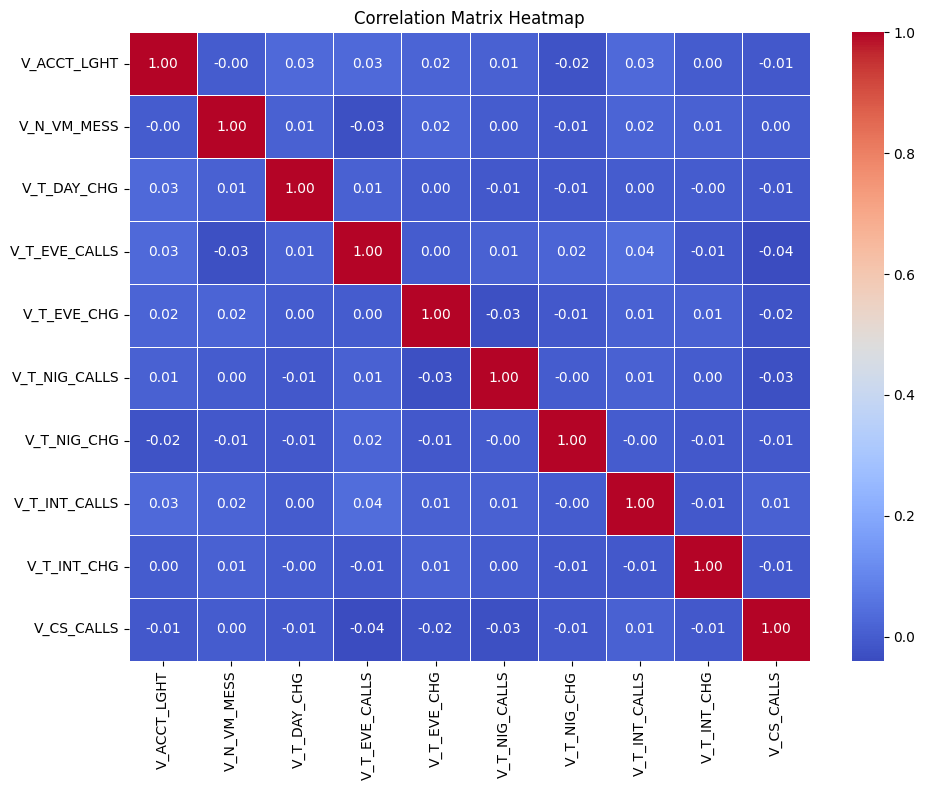

In [13]:
corr_matrix = train[varc].corr().round(2)
display(corr_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()

In [14]:
vc = VarClusHi(df=train,feat_list=varc).varclus()
rs = vc.rsquare.sort_values(by=['Cluster','RS_Ratio'])
display(rs)
mc = list(rs.groupby('Cluster').first()['Variable'])
mc

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
2,0,V_CS_CALLS,0.454707,0.000292,0.545452
0,0,V_T_EVE_CALLS,0.370389,0.000774,0.630099
1,0,V_T_NIG_CALLS,0.228412,0.000115,0.771677
4,1,V_T_DAY_CHG,0.517043,0.000051,0.482982
3,1,V_ACCT_LGHT,0.517043,0.000873,0.483379
6,2,V_T_INT_CHG,0.507319,0.000014,0.492688
5,2,V_T_NIG_CHG,0.507319,0.000394,0.492876
7,3,V_N_VM_MESS,0.392771,0.000185,0.607341
9,3,V_T_INT_CALLS,0.373567,0.000585,0.626800
8,3,V_T_EVE_CHG,0.271287,0.000191,0.728853


['V_CS_CALLS', 'V_T_DAY_CHG', 'V_T_INT_CHG', 'V_N_VM_MESS']

#### Distribuciones 

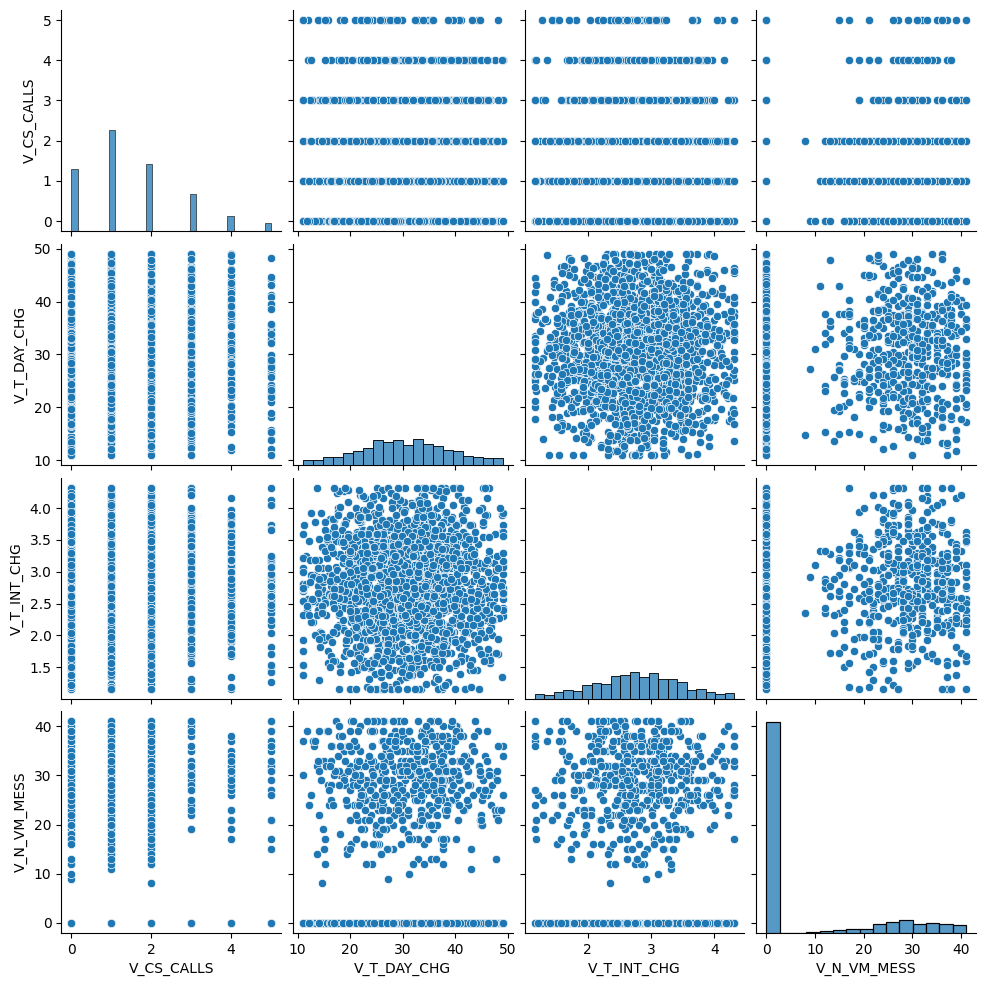

In [15]:
sns.pairplot(train[mc])

### Discreto

#### Frecuencias 

In [16]:
frequency_table(train,vard)

**** Frequency Table for C_IP ****

      Abs. Freq.  Rel. Freq.  Cum. Abs. Freq.  Cum. Rel. Freq.
C_IP                                                          
No          1772    0.904082             1772         0.904082
Yes          188    0.095918             1960         1.000000




**** Frequency Table for C_VMP ****

       Abs. Freq.  Rel. Freq.  Cum. Abs. Freq.  Cum. Rel. Freq.
C_VMP                                                          
No           1420     0.72449             1420          0.72449
Yes           540     0.27551             1960          1.00000






#### Normalización 

In [18]:
dn = DiscreteNormalizer(normalization_threshold=0.1,default_category='OTROS')
dn.fit(train[vard])
train_norm = dn.transform(train[vard])
frequency_table(train_norm,vard)

**** Frequency Table for C_IP ****

      Abs. Freq.  Rel. Freq.  Cum. Abs. Freq.  Cum. Rel. Freq.
C_IP                                                          
No          1960         1.0             1960              1.0




**** Frequency Table for C_VMP ****

       Abs. Freq.  Rel. Freq.  Cum. Abs. Freq.  Cum. Rel. Freq.
C_VMP                                                          
No           1420     0.72449             1420          0.72449
Yes           540     0.27551             1960          1.00000






In [20]:
fuera = [v for v in train_norm.columns if train_norm[v].nunique() == 1]
print(fuera)
vard = [v for v in vard if v not in fuera]
dn.fit(train_norm[vard])

['C_IP']


#### Encoding 

In [28]:
oh = OneHotEncoder(sparse_output=False,drop='if_binary')
oh.fit(train[vard])
varoh = list(oh.get_feature_names_out(vard))
varoh
train[varoh] = oh.transform(train_norm[vard])

## Conjunto de entrenamiento $S_n = \{(x^{(i)},y^{(i)})|i=1,2,\dots,n\}$

In [31]:
Sn = train[um+mc+varoh+vart].copy()
Sn.head()

,ID,V_CS_CALLS,V_T_DAY_CHG,V_T_INT_CHG,V_N_VM_MESS,C_VMP_Yes,TARGET
0,127.0,4.0,12.02,2.46,0.0,0.0,1.0
1,1624.0,1.0,29.97,3.05,0.0,0.0,0.0
2,2889.0,1.0,13.19,2.94,36.0,1.0,0.0
3,1060.0,1.0,40.66,2.38,0.0,0.0,0.0
4,668.0,0.0,32.95,2.48,0.0,0.0,0.0


In [33]:
frequency_table(Sn,vart)

**** Frequency Table for TARGET ****

        Abs. Freq.  Rel. Freq.  Cum. Abs. Freq.  Cum. Rel. Freq.
TARGET                                                          
0.0           1701    0.867857             1701         0.867857
1.0            259    0.132143             1960         1.000000






## Aprendizaje 

In [39]:
var = mc+varoh

### Híperparametrización 

In [63]:
dt = DecisionTreeClassifier()

In [87]:
# Espacio Híper-paramétrico
hparam_grid = {
    'criterion': ['gini','entropy','log_loss'],
    'splitter': ['best','random'],
    'max_depth': np.arange(2,5),
    'min_samples_split': np.arange(0.1,0.2,0.01),
    'min_samples_leaf': np.arange(0.1,0.2,0.01),
    'max_features': ['sqrt','log2']
}
reduce(lambda x,y: x*y, [len(hparam_grid[k]) for k in hparam_grid])

3600

In [88]:
grid = GridSearchCV(estimator=dt,
                    param_grid=hparam_grid,
                    cv=5,
                    scoring='roc_auc',
                    n_jobs=-1,
                    verbose=1)
grid.fit(Sn[var],Sn[vart[0]])


Fitting 5 folds for each of 3600 candidates, totalling 18000 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=np.int64(4),
                                              max_features='log2',
                                              min_samples_leaf=np.float64(0.07),
                                              min_samples_split=np.float64(0.07)),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': array([2, 3, 4]),
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': array([0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19]),
                         'min_samples_split': array([0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19]),
                         'splitter': ['best', 'random']},
             scoring='roc_auc', verbose=1)

In [89]:
grid.best_score_

np.float64(0.7740115245286023)

In [90]:
dt = grid.best_estimator_

In [91]:
dt

DecisionTreeClassifier(max_depth=np.int64(4), max_features='sqrt',
                       min_samples_leaf=np.float64(0.11),
                       min_samples_split=np.float64(0.15999999999999998))

### Entrenamiento 

In [92]:
dt.fit(Sn[var],Sn[vart[0]])

DecisionTreeClassifier(max_depth=np.int64(4), max_features='sqrt',
                       min_samples_leaf=np.float64(0.11),
                       min_samples_split=np.float64(0.15999999999999998))

[Text(0.7142857142857143, 0.9, 'V_CS_CALLS <= 2.5\ngini = 0.229\nsamples = 100.0%\nvalue = [0.868, 0.132]'),
 Text(0.5714285714285714, 0.7, 'V_T_DAY_CHG <= 40.145\ngini = 0.179\nsamples = 79.4%\nvalue = [0.9, 0.1]'),
 Text(0.6428571428571428, 0.8, 'True  '),
 Text(0.42857142857142855, 0.5, 'V_T_INT_CHG <= 3.47\ngini = 0.102\nsamples = 68.3%\nvalue = [0.946, 0.054]'),
 Text(0.2857142857142857, 0.3, 'V_N_VM_MESS <= 24.5\ngini = 0.079\nsamples = 56.9%\nvalue = [0.959, 0.041]'),
 Text(0.14285714285714285, 0.1, 'gini = 0.075\nsamples = 45.8%\nvalue = [0.961, 0.039]'),
 Text(0.42857142857142855, 0.1, 'gini = 0.096\nsamples = 11.1%\nvalue = [0.949, 0.051]'),
 Text(0.5714285714285714, 0.3, 'gini = 0.205\nsamples = 11.4%\nvalue = [0.884, 0.116]'),
 Text(0.7142857142857143, 0.5, 'gini = 0.472\nsamples = 11.1%\nvalue = [0.618, 0.382]'),
 Text(0.8571428571428571, 0.7, 'gini = 0.382\nsamples = 20.6%\nvalue = [0.743, 0.257]'),
 Text(0.7857142857142857, 0.8, '  False')]

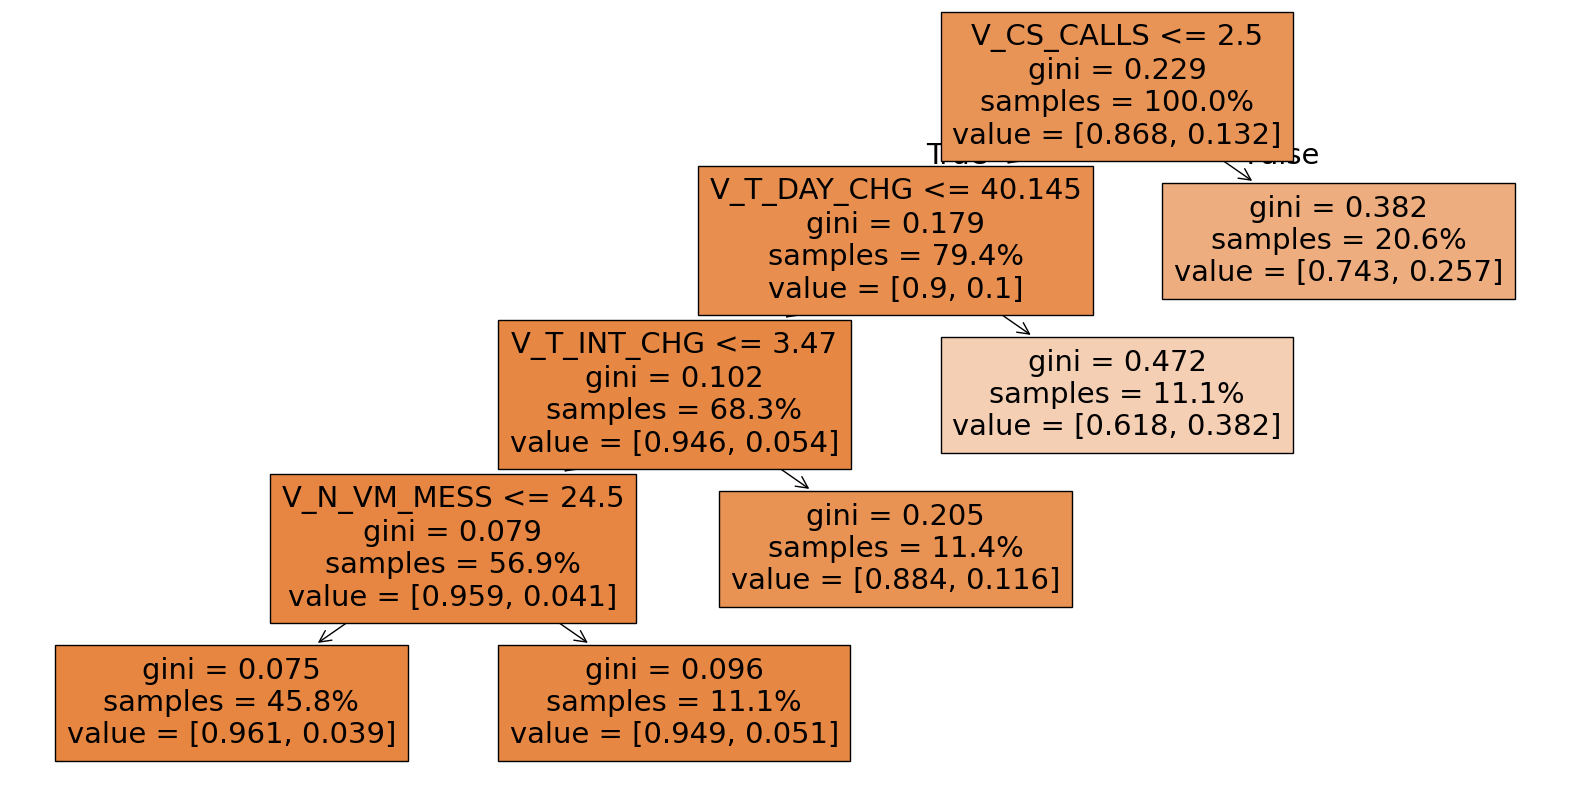

In [93]:
plt.figure(figsize=(20,10))
plot_tree(dt, filled=True, feature_names=var, proportion=True)

### Validación del modelo 

In [94]:
Sn1 = valid[um+mc+vard+vart].copy()

In [95]:
Sn1[varoh] = oh.transform(dn.transform(Sn1[vard]))

In [96]:
Sn1 = Sn1[um+var+vart]

In [97]:
{'roc_auc_entrenamiento':roc_auc_score(y_score=dt.predict_proba(Sn[var])[:,1],y_true=Sn[vart[0]]),
 'roc_auc_validacion':roc_auc_score(y_score=dt.predict_proba(Sn1[var])[:,1],y_true=Sn1[vart[0]])
 }

{'roc_auc_entrenamiento': np.float64(0.7696733014193331),
 'roc_auc_validacion': np.float64(0.7186315302820157)}

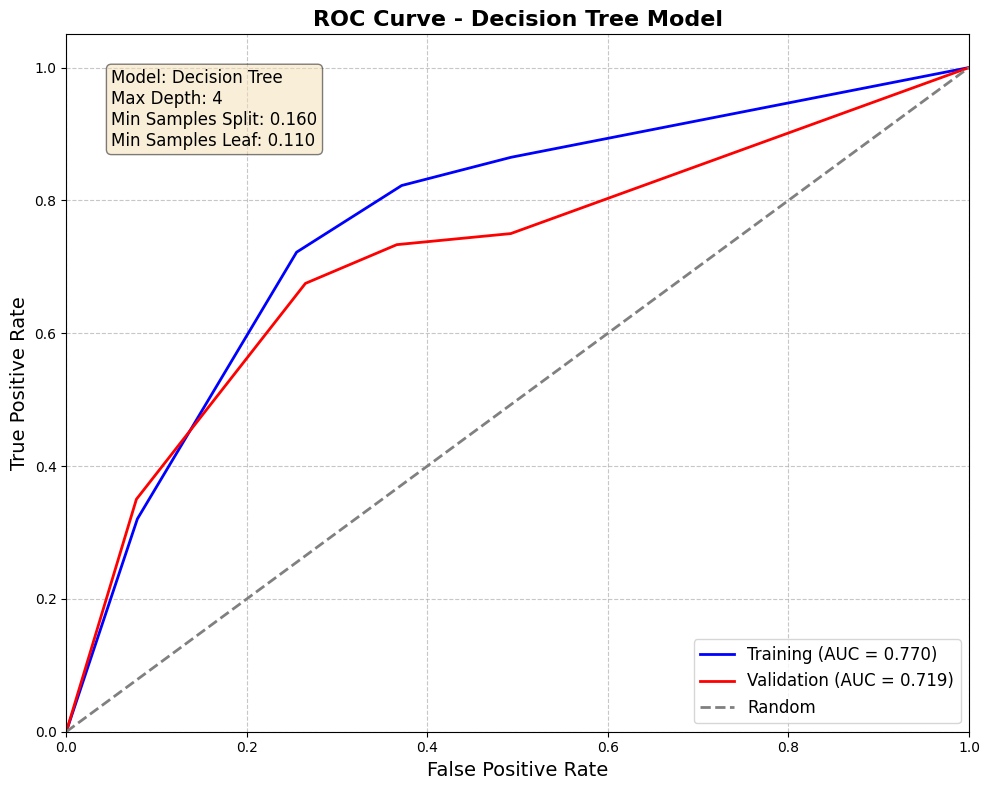

In [98]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Get predictions for training and validation sets
y_train_true = Sn[vart[0]]
y_train_pred = dt.predict_proba(Sn[var])[:,1]

y_valid_true = Sn1[vart[0]]
y_valid_pred = dt.predict_proba(Sn1[var])[:,1]

# Calculate ROC curve points
fpr_train, tpr_train, _ = roc_curve(y_train_true, y_train_pred)
fpr_valid, tpr_valid, _ = roc_curve(y_valid_true, y_valid_pred)

# Create a beautiful plot
plt.figure(figsize=(10, 8))

# Plot both curves
plt.plot(fpr_train, tpr_train, color='blue', lw=2, 
         label=f'Training (AUC = {roc_auc_score(y_train_true, y_train_pred):.3f})')
plt.plot(fpr_valid, tpr_valid, color='red', lw=2, 
         label=f'Validation (AUC = {roc_auc_score(y_valid_true, y_valid_pred):.3f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random')

# Add labels and title
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve - Decision Tree Model', fontsize=16, fontweight='bold')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right', fontsize=12)

# Add a text box with model details
textstr = '\n'.join([
    'Model: Decision Tree',
    f'Max Depth: {dt.max_depth}',
    f'Min Samples Split: {dt.min_samples_split:.3f}',
    f'Min Samples Leaf: {dt.min_samples_leaf:.3f}'
])
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()
